In [1]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!kaggle datasets download -d debashish0sarker/captcha-shortened

Dataset URL: https://www.kaggle.com/datasets/debashish0sarker/captcha-shortened
License(s): unknown
100% 3.35G/3.35G [00:24<00:00, 238MB/s]
100% 3.35G/3.35G [00:24<00:00, 147MB/s]


In [3]:
!unzip captcha-shortened.zip -d captcha_shortened

Streaming output truncated to the last 5000 lines.
  inflating: captcha_shortened/SPHINX_shortened/ZOUA_378480.png  
  inflating: captcha_shortened/SPHINX_shortened/ZOUB_423764.png  
  inflating: captcha_shortened/SPHINX_shortened/ZOUC_118519.png  
  inflating: captcha_shortened/SPHINX_shortened/ZOUC_601525.png  
  inflating: captcha_shortened/SPHINX_shortened/ZOUF_386752.png  
  inflating: captcha_shortened/SPHINX_shortened/ZOUG_855976.png  
  inflating: captcha_shortened/SPHINX_shortened/ZOUI_232716.png  
  inflating: captcha_shortened/SPHINX_shortened/ZOUI_709128.png  
  inflating: captcha_shortened/SPHINX_shortened/ZOUJ_524944.png  
  inflating: captcha_shortened/SPHINX_shortened/ZOUJ_814891.png  
  inflating: captcha_shortened/SPHINX_shortened/ZOUO_195100.png  
  inflating: captcha_shortened/SPHINX_shortened/ZOUO_317513.png  
  inflating: captcha_shortened/SPHINX_shortened/ZOUP_563916.png  
  inflating: captcha_shortened/SPHINX_shortened/ZOUQ_404157.png  
  inflating: captcha_shor

In [9]:
!pip install torchsummary scikit-learn psutil --quiet


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, time, random, psutil
from PIL import Image
import string

from sklearn.metrics import classification_report, confusion_matrix


In [34]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device.type == "cuda":
    torch.cuda.manual_seed_all(SEED)

# Hyperparameters
BATCH_SIZE     = 64
EPOCHS         = 10
LEARNING_RATE  = 1e-3
NUM_CHARS      = 4                      # captcha length
ALPHABET       = string.ascii_uppercase # A-Z
NUM_CLASSES    = len(ALPHABET)
VAL_SPLIT      = 0.2

# Training options
USE_AMP = True                          # automatic mixed precision for speed
NUM_WORKERS = 2                         # Kaggle is fine with 2
PIN_MEMORY  = device.type == "cuda"

# Checkpointing
CKPT_DIR = "/kaggle/working/checkpoints"
os.makedirs(CKPT_DIR, exist_ok=True)
LATEST_CKPT = os.path.join(CKPT_DIR, "latest_checkpoint.pth")
BEST_CKPT   = os.path.join(CKPT_DIR, "best_model.pth")

# Data directory (UPDATE THIS)
DATA_DIR = "/content/captcha_shortened/SPHINX_shortened"


Using device: cuda


In [35]:
class CAPTCHADataset(Dataset):
    """
    Expects filenames like 'ABCD_xxx.png' where the first 4 chars are the label.
    Uses only uppercase A-Z characters.
    """
    def __init__(self, data_dir, transform=None, num_chars=4, alphabet=string.ascii_uppercase):
        self.data_dir = data_dir
        self.transform = transform
        self.num_chars = num_chars
        self.alphabet = alphabet

        self.char_to_idx = {c: i for i, c in enumerate(self.alphabet)}
        self.idx_to_char = {i: c for c, i in self.char_to_idx.items()}

        self.image_paths, self.labels = [], []

        for fname in sorted(os.listdir(data_dir)):
            if fname.lower().endswith((".png", ".jpg", ".jpeg")):
                # label is first num_chars characters before underscore
                label_str = fname.split("_")[0][:num_chars].upper()
                if len(label_str) == num_chars and all(c in self.alphabet for c in label_str):
                    self.image_paths.append(os.path.join(data_dir, fname))
                    label_indices = [self.char_to_idx[c] for c in label_str]
                    self.labels.append(torch.tensor(label_indices, dtype=torch.long))

        if len(self.image_paths) == 0:
            raise RuntimeError(f"No valid images found in {data_dir}. Check filenames and path.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        # Convert to grayscale
        image = Image.open(img_path).convert("L")  # Convert to grayscale
        label = self.labels[idx]                   # shape [num_chars]

        if self.transform:
            image = self.transform(image)          # shape [1, H, W] after transform

        return image, label

# Transforms: resize to a stable size; normalize to [-1, 1]
transform = transforms.Compose([
    transforms.Resize((40, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])


In [36]:
def get_data_loaders(data_dir, batch_size=64, val_split=0.2):
    dataset = CAPTCHADataset(data_dir, transform=transform, num_chars=NUM_CHARS, alphabet=ALPHABET)

    # Safe split (ensure at least 1 sample in val if possible)
    val_size = max(1, int(len(dataset) * val_split)) if len(dataset) > 1 else 0
    train_size = len(dataset) - val_size

    train_dataset, val_dataset = random_split(
        dataset,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(SEED)
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                              num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False,
                              num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

    print(f"📊 Dataset loaded: {len(dataset)} images")
    print(f"📈 Training: {len(train_dataset)} images")
    print(f"📉 Validation: {len(val_dataset)} images")

    # expose for inference helpers
    return dataset, train_loader, val_loader

dataset, train_loader, val_loader = get_data_loaders(DATA_DIR, BATCH_SIZE, VAL_SPLIT)

📊 Dataset loaded: 370142 images
📈 Training: 296114 images
📉 Validation: 74028 images


In [37]:
class CAPTCHA_OCR(nn.Module):
    def __init__(self, num_chars=NUM_CHARS, num_classes=NUM_CLASSES):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1,32,3,padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128,256,3,padding=1), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(256,512,3,padding=1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,9))
        )
        self.fc_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(512,256), nn.ReLU(), nn.Dropout(0.3), nn.Linear(256,num_classes)
            ) for _ in range(num_chars)
        ])
    def forward(self,x):
        f = self.features(x).squeeze(2).permute(0,2,1) # (B,9,512)
        outs=[]
        for i in range(NUM_CHARS):
            idx = min(i, f.size(1)-1)
            outs.append(self.fc_layers[i](f[:,idx,:]))
        return torch.stack(outs,dim=1)

# Init model
model = CAPTCHA_OCR().to(device)
print("✅ OCR model defined!")


✅ OCR model defined!


In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", patience=3, factor=0.5
)


In [40]:
def calculate_accuracy(outputs, labels):
    preds = torch.argmax(outputs, dim=2)
    char_acc = (preds == labels).sum().item() / labels.numel()
    captcha_acc = (preds == labels).all(dim=1).sum().item() / labels.size(0)
    return char_acc, captcha_acc


In [43]:
from tqdm import tqdm

def train_model(model, train_loader, val_loader, epochs=EPOCHS):
    ckpt_dir = "/kaggle/working/checkpoints"
    os.makedirs(ckpt_dir, exist_ok=True)
    best_val = 0
    history = {"train_loss":[],"val_loss":[],"train_char_acc":[],"val_char_acc":[],"train_captcha_acc":[],"val_captcha_acc":[]}

    for epoch in range(epochs):
        # --- Train ---
        model.train(); train_loss=0; tchar=tcapt=0; tchar_tot=tcapt_tot=0
        for imgs,labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
            imgs,labels=imgs.to(device),labels.to(device)
            optimizer.zero_grad()
            outs=model(imgs)
            loss=criterion(outs.view(-1,NUM_CLASSES), labels.view(-1))
            loss.backward(); optimizer.step()
            train_loss+=loss.item()
            c_acc,cap_acc=calculate_accuracy(outs,labels)
            tchar+=c_acc*labels.numel(); tchar_tot+=labels.numel()
            tcapt+=cap_acc*labels.size(0); tcapt_tot+=labels.size(0)

        # --- Val ---
        model.eval(); val_loss=0; vchar=vcapt=0; vchar_tot=vcapt_tot=0
        with torch.no_grad():
            for imgs,labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]"):
                imgs,labels=imgs.to(device),labels.to(device)
                outs=model(imgs)
                loss=criterion(outs.view(-1,NUM_CLASSES), labels.view(-1))
                val_loss+=loss.item()
                c_acc,cap_acc=calculate_accuracy(outs,labels)
                vchar+=c_acc*labels.numel(); vchar_tot+=labels.numel()
                vcapt+=cap_acc*labels.size(0); vcapt_tot+=labels.size(0)

        # Averages
        train_char_acc, train_captcha_acc = tchar/tchar_tot, tcapt/tcapt_tot
        val_char_acc, val_captcha_acc = vchar/vchar_tot, vcapt/vcapt_tot
        avg_train_loss, avg_val_loss = train_loss/len(train_loader), val_loss/len(val_loader)

        scheduler.step(avg_val_loss)
        lr = optimizer.param_groups[0]["lr"]

        # Save metrics
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_char_acc'].append(train_char_acc)
        history['val_char_acc'].append(val_char_acc)
        history['train_captcha_acc'].append(train_captcha_acc)
        history['val_captcha_acc'].append(val_captcha_acc)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss {avg_train_loss:.4f}, Val Loss {avg_val_loss:.4f}, Val Char Acc {val_char_acc:.4f}, Val CAPTCHA Acc {val_captcha_acc:.4f}, LR {lr:.6f}")

        # Save checkpoints
        torch.save({'epoch':epoch+1,'model_state_dict':model.state_dict(),'optimizer_state_dict':optimizer.state_dict(),'history':history}, f"{ckpt_dir}/epoch_{epoch+1:03d}.pth")
        torch.save({'model_state_dict':model.state_dict()}, f"{ckpt_dir}/latest.pth")
        if val_char_acc>best_val:
            best_val=val_char_acc
            torch.save({'epoch':epoch+1,'model_state_dict':model.state_dict(),'val_char_acc':val_char_acc,'val_captcha_acc':val_captcha_acc}, f"{ckpt_dir}/best_model.pth")
            print("✅ New best model saved!")

    torch.save({'model_state_dict':model.state_dict(),'history':history}, f"{ckpt_dir}/final_model.pth")
    return history


In [44]:
history = train_model(model, train_loader, val_loader, epochs=EPOCHS)


Epoch 1/10 [Val]: 100%|██████████| 1157/1157 [00:55<00:00, 20.74it/s]


Epoch 1/10 | Train Loss 0.8824, Val Loss 0.8011, Val Char Acc 0.7324, Val CAPTCHA Acc 0.4422, LR 0.001000
✅ New best model saved!


Epoch 2/10 [Val]: 100%|██████████| 1157/1157 [00:50<00:00, 22.71it/s]


Epoch 2/10 | Train Loss 0.7922, Val Loss 0.7719, Val Char Acc 0.7405, Val CAPTCHA Acc 0.4612, LR 0.001000
✅ New best model saved!


Epoch 3/10 [Val]: 100%|██████████| 1157/1157 [00:50<00:00, 22.76it/s]


Epoch 3/10 | Train Loss 0.7603, Val Loss 0.7462, Val Char Acc 0.7481, Val CAPTCHA Acc 0.4783, LR 0.001000
✅ New best model saved!


Epoch 4/10 [Val]: 100%|██████████| 1157/1157 [00:50<00:00, 22.75it/s]


Epoch 4/10 | Train Loss 0.7408, Val Loss 0.7328, Val Char Acc 0.7526, Val CAPTCHA Acc 0.4852, LR 0.001000
✅ New best model saved!


Epoch 5/10 [Val]: 100%|██████████| 1157/1157 [00:47<00:00, 24.52it/s]


Epoch 5/10 | Train Loss 0.7274, Val Loss 0.7261, Val Char Acc 0.7542, Val CAPTCHA Acc 0.4911, LR 0.001000
✅ New best model saved!


Epoch 6/10 [Val]: 100%|██████████| 1157/1157 [00:41<00:00, 27.97it/s]


Epoch 6/10 | Train Loss 0.7167, Val Loss 0.7238, Val Char Acc 0.7548, Val CAPTCHA Acc 0.4918, LR 0.001000
✅ New best model saved!


Epoch 7/10 [Val]: 100%|██████████| 1157/1157 [00:41<00:00, 28.11it/s]


Epoch 7/10 | Train Loss 0.7081, Val Loss 0.7185, Val Char Acc 0.7560, Val CAPTCHA Acc 0.4939, LR 0.001000
✅ New best model saved!


Epoch 8/10 [Val]: 100%|██████████| 1157/1157 [00:41<00:00, 28.15it/s]


Epoch 8/10 | Train Loss 0.7010, Val Loss 0.7144, Val Char Acc 0.7580, Val CAPTCHA Acc 0.4991, LR 0.001000
✅ New best model saved!


Epoch 9/10 [Val]: 100%|██████████| 1157/1157 [00:41<00:00, 27.70it/s]


Epoch 9/10 | Train Loss 0.6954, Val Loss 0.7104, Val Char Acc 0.7591, Val CAPTCHA Acc 0.5009, LR 0.001000
✅ New best model saved!


Epoch 10/10 [Val]: 100%|██████████| 1157/1157 [00:41<00:00, 27.83it/s]


Epoch 10/10 | Train Loss 0.6903, Val Loss 0.7143, Val Char Acc 0.7580, Val CAPTCHA Acc 0.5005, LR 0.001000


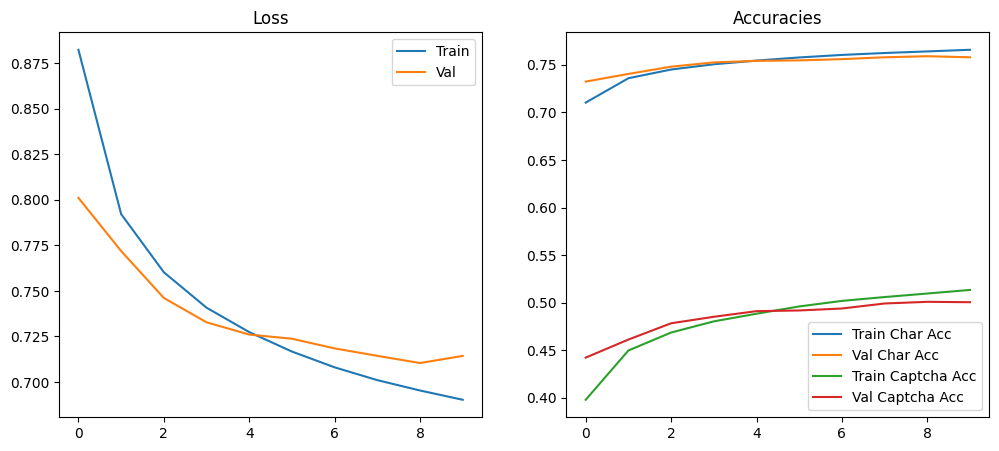

In [45]:
def plot_history(h):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(h['train_loss'],label="Train"); plt.plot(h['val_loss'],label="Val")
    plt.title("Loss"); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(h['train_char_acc'],label="Train Char Acc"); plt.plot(h['val_char_acc'],label="Val Char Acc")
    plt.plot(h['train_captcha_acc'],label="Train Captcha Acc"); plt.plot(h['val_captcha_acc'],label="Val Captcha Acc")
    plt.title("Accuracies"); plt.legend()
    plt.show()

plot_history(history)


              precision    recall  f1-score   support

           A       0.76      0.76      0.76     13237
           B       0.74      0.65      0.69     12852
           C       0.54      0.71      0.61     13248
           D       0.83      0.71      0.77     12812
           E       0.77      0.62      0.68     12668
           F       0.82      0.59      0.69     11443
           G       0.84      0.64      0.73     10754
           H       0.51      0.74      0.60     10620
           I       0.96      0.88      0.92      8966
           J       0.78      0.97      0.86      9105
           K       0.55      0.72      0.63     10433
           L       0.72      0.93      0.81      8952
           M       0.74      0.79      0.76     10468
           N       0.77      0.74      0.75     12875
           O       0.91      0.89      0.90      9211
           P       0.85      0.67      0.75     13155
           Q       0.87      0.97      0.92      8890
           R       0.49    

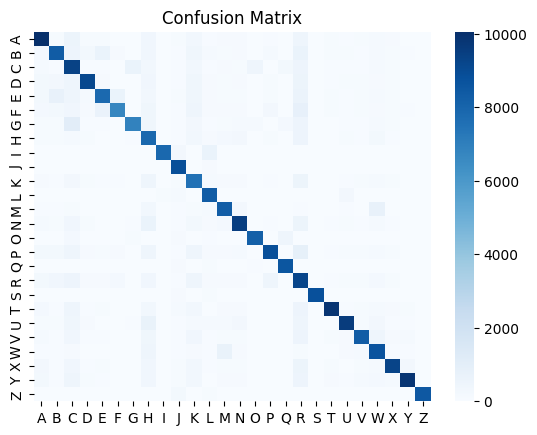

In [46]:
def evaluate(model,loader):
    model.eval(); preds,labels_all=[],[]
    with torch.no_grad():
        for imgs,labels in loader:
            imgs,labels=imgs.to(device),labels.to(device)
            outs=model(imgs)
            p=torch.argmax(outs,dim=2).cpu().numpy().flatten()
            l=labels.cpu().numpy().flatten()
            preds.extend(p); labels_all.extend(l)
    print(classification_report(labels_all,preds,target_names=list(ALPHABET)))
    cm=confusion_matrix(labels_all,preds,labels=list(range(NUM_CLASSES)))
    sns.heatmap(cm,xticklabels=ALPHABET,yticklabels=ALPHABET,cmap="Blues")
    plt.title("Confusion Matrix"); plt.show()

evaluate(model,val_loader)


In [47]:
import random

def show_predictions_examples(model, loader, max_correct=10, max_wrong=10):
    model.eval()
    correct_samples, wrong_samples = [], []
    all_preds, all_labels = [], []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outs = model(imgs)
            preds = torch.argmax(outs, dim=2)

            for i in range(imgs.size(0)):
                gt = "".join(ALPHABET[c.item()] for c in labels[i])
                pd = "".join(ALPHABET[p.item()] for p in preds[i])

                all_labels.append(gt)
                all_preds.append(pd)

                if gt == pd and len(correct_samples) < max_correct:
                    correct_samples.append((imgs[i].cpu(), gt, pd))
                elif gt != pd and len(wrong_samples) < max_wrong:
                    wrong_samples.append((imgs[i].cpu(), gt, pd))

            # stop early if we already collected enough
            if len(correct_samples) >= max_correct and len(wrong_samples) >= max_wrong:
                break

    # --- Display Correct ---
    print(f"\n✅ Showing {len(correct_samples)} Correct Predictions:")
    fig, axes = plt.subplots(1, len(correct_samples), figsize=(18,3))
    for ax, (img, gt, pd) in zip(axes, correct_samples):
        ax.imshow(img.squeeze(0), cmap="gray")
        ax.set_title(f"GT: {gt}\nPD: {pd}", fontsize=10, color="green")
        ax.axis("off")
    plt.show()

    # --- Display Wrong ---
    print(f"\n❌ Showing {len(wrong_samples)} Wrong Predictions:")
    fig, axes = plt.subplots(1, len(wrong_samples), figsize=(18,3))
    for ax, (img, gt, pd) in zip(axes, wrong_samples):
        ax.imshow(img.squeeze(0), cmap="gray")
        ax.set_title(f"GT: {gt}\nPD: {pd}", fontsize=10, color="red")
        ax.axis("off")
    plt.show()

    # --- Final Validation Summary ---
    total = len(all_labels)
    correct = sum([g==p for g,p in zip(all_labels, all_preds)])
    print(f"📊 Final Validation Accuracy: {correct}/{total} = {correct/total:.2%}")

    return all_labels, all_preds



✅ Showing 10 Correct Predictions:


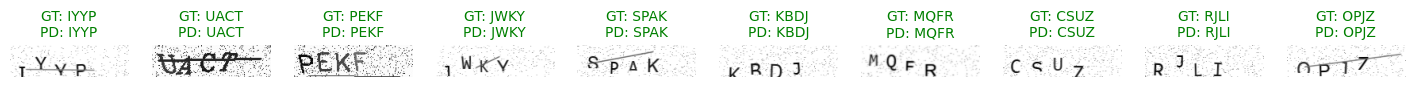


❌ Showing 10 Wrong Predictions:


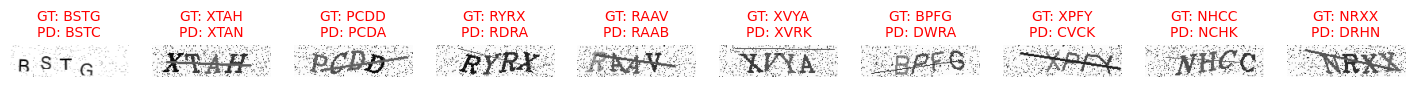

📊 Final Validation Accuracy: 39/64 = 60.94%


In [48]:
labels, preds = show_predictions_examples(model, val_loader, max_correct=10, max_wrong=10)


In [50]:
import pandas as _pd  # use alias that won’t be accidentally overwritten

def save_all_val_predictions(model, loader, out_csv="/kaggle/working/val_predictions.csv"):
    model.eval()
    all_gt, all_pred = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Validating"):
            imgs, labels = imgs.to(device), labels.to(device)
            outs = model(imgs)
            preds = torch.argmax(outs, dim=2)

            for i in range(imgs.size(0)):
                gt = "".join(ALPHABET[c.item()] for c in labels[i])
                pd = "".join(ALPHABET[p.item()] for p in preds[i])
                all_gt.append(gt)
                all_pred.append(pd)

    # Save to CSV
    df = _pd.DataFrame({"GroundTruth": all_gt, "Prediction": all_pred})
    df.to_csv(out_csv, index=False)
    print(f"✅ Saved {len(df)} validation predictions to {out_csv}")

    # Print summary
    acc = (df["GroundTruth"] == df["Prediction"]).mean()
    print(f"📊 Final Validation Accuracy (full set): {acc:.2%}")
    return df


In [51]:
val_df = save_all_val_predictions(model, val_loader)

Validating: 100%|██████████| 1157/1157 [00:49<00:00, 23.18it/s]


✅ Saved 74028 validation predictions to /kaggle/working/val_predictions.csv
📊 Final Validation Accuracy (full set): 50.05%


📦 Model size: 8.51 MB
              precision    recall  f1-score   support

           A       0.76      0.76      0.76     13237
           B       0.74      0.65      0.69     12852
           C       0.54      0.71      0.61     13248
           D       0.83      0.71      0.77     12812
           E       0.77      0.62      0.68     12668
           F       0.82      0.59      0.69     11443
           G       0.84      0.64      0.73     10754
           H       0.51      0.74      0.60     10620
           I       0.96      0.88      0.92      8966
           J       0.78      0.97      0.86      9105
           K       0.55      0.72      0.63     10433
           L       0.72      0.93      0.81      8952
           M       0.74      0.79      0.76     10468
           N       0.77      0.74      0.75     12875
           O       0.91      0.89      0.90      9211
           P       0.85      0.67      0.75     13155
           Q       0.87      0.97      0.92      8890
     

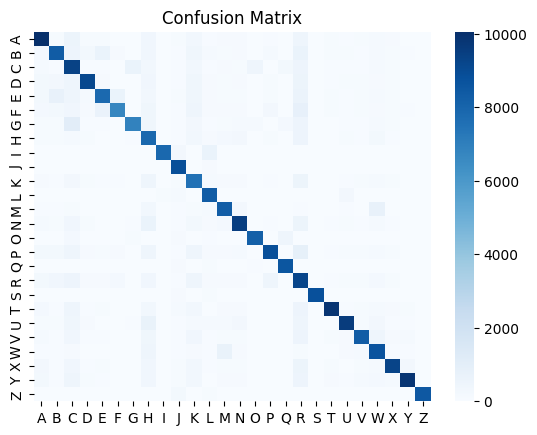

⏱️ Inference Latency: 42.82s
💾 RAM Usage: 22.9%
GPU Memory Allocated: 53.12 MB


In [52]:
torch.save(model.state_dict(), "/kaggle/working/model_size.pth")
print(f"📦 Model size: {os.path.getsize('/kaggle/working/model_size.pth')/1e6:.2f} MB")

start=time.time()
evaluate(model,val_loader)
print(f"⏱️ Inference Latency: {time.time()-start:.2f}s")
print(f"💾 RAM Usage: {psutil.virtual_memory().percent}%")
if torch.cuda.is_available():
    print(f"GPU Memory Allocated: {torch.cuda.memory_allocated()/1e6:.2f} MB")


In [53]:
from sklearn.metrics import classification_report
print(classification_report(list("".join(val_df["GroundTruth"])),
                            list("".join(val_df["Prediction"])),
                            target_names=list(ALPHABET)))


              precision    recall  f1-score   support

           A       0.76      0.76      0.76     13237
           B       0.74      0.65      0.69     12852
           C       0.54      0.71      0.61     13248
           D       0.83      0.71      0.77     12812
           E       0.77      0.62      0.68     12668
           F       0.82      0.59      0.69     11443
           G       0.84      0.64      0.73     10754
           H       0.51      0.74      0.60     10620
           I       0.96      0.88      0.92      8966
           J       0.78      0.97      0.86      9105
           K       0.55      0.72      0.63     10433
           L       0.72      0.93      0.81      8952
           M       0.74      0.79      0.76     10468
           N       0.77      0.74      0.75     12875
           O       0.91      0.89      0.90      9211
           P       0.85      0.67      0.75     13155
           Q       0.87      0.97      0.92      8890
           R       0.49    

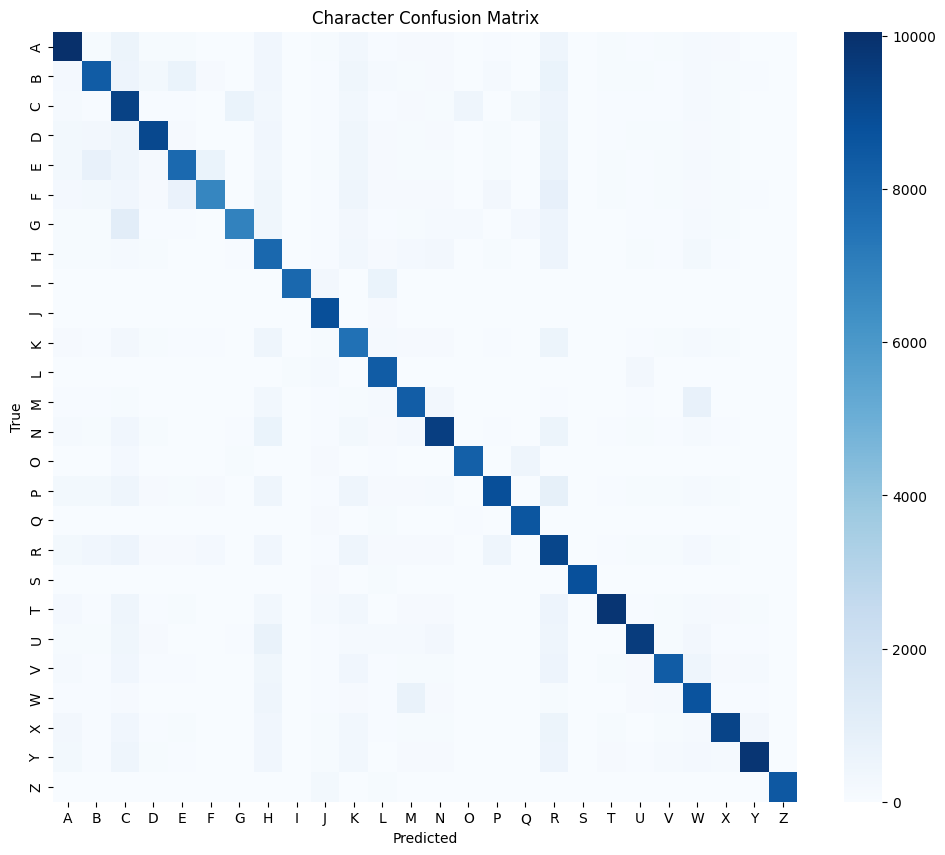

In [54]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

chars_true = list("".join(val_df["GroundTruth"]))
chars_pred = list("".join(val_df["Prediction"]))
cm = confusion_matrix(chars_true, chars_pred, labels=list(ALPHABET))

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=False, xticklabels=ALPHABET, yticklabels=ALPHABET, cmap="Blues")
plt.title("Character Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [55]:
from google.colab import files
uploaded = files.upload()


Saving ca772655-b134-4f7c-bd0f-6a4fa1e216e6.jpg to ca772655-b134-4f7c-bd0f-6a4fa1e216e6.jpg


In [58]:
def predict_captcha(model, img_path, transform=transform):
    model.eval()
    image = Image.open(img_path).convert("L")   # grayscale
    image = transform(image).unsqueeze(0).to(device)  # [1,1,H,W]

    with torch.no_grad():
        output = model(image)  # [1, num_chars, num_classes]
        preds = torch.argmax(output, dim=2)[0]  # [num_chars]

    prediction = "".join(ALPHABET[i.item()] for i in preds)
    return prediction


In [59]:
import matplotlib.pyplot as plt
import os

def show_test_prediction(model, img_path):
    # Get prediction
    pred = predict_captcha(model, img_path)

    # Ground truth from filename (if available)
    fname = os.path.basename(img_path)
    gt = fname.split("_")[0][:NUM_CHARS].upper()

    # Show image
    img = Image.open(img_path).convert("L")
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.title(f"GT: {gt} | PD: {pred}", fontsize=14,
              color=("green" if gt == pred else "red"))
    plt.show()

    print(f"✅ Ground Truth: {gt}")
    print(f"🤖 Prediction:   {pred}")


Saving 993e4918-7d29-403c-9cbe-6d19aa71fd25.jpg to 993e4918-7d29-403c-9cbe-6d19aa71fd25.jpg


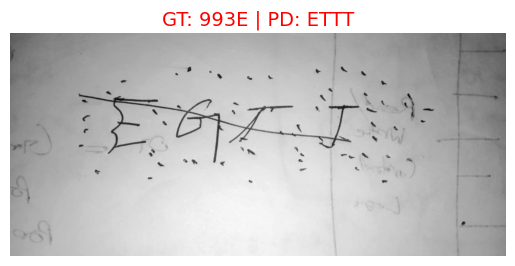

✅ Ground Truth: 993E
🤖 Prediction:   ETTT


In [60]:
from google.colab import files
uploaded = files.upload()

test_img_path = list(uploaded.keys())[0]  # get uploaded filename
show_test_prediction(model, test_img_path)
